In [1]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 
import pandas as pd
import PIL
import numpy as np 
import matplotlib.pyplot as plt
from easyimages import EasyImageList
from torch import nn
import torch
from sklearn.metrics import accuracy_score, classification_report, log_loss
import torch.nn.functional as F
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


### Define the new dataset

Keep in mind we are inheriting the Dataset base-class. And we have to override 2 methods:
 - \____len____
 - \____getitem____

1. load_image_and_target reads the data from the csv file and converts the image array into a PIL object - this is not mandatory but useful, as many handy functions like transform, operate on PIL.Images
2. getitem, takes a index and it should properly return for every number between (0, and len)
3. len should return the number of samples (images) in your dataset

In [2]:
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}


class FashionMnist(Dataset):

    def __len__(self):
        return len(self.metadata_df)

    def __init__(self, metadata_df,
                 transform=None):
        
        self.metadata_df = metadata_df.copy()
        self.transform = transform
    
    def load_image_and_target(self,index):
        # .iloc is short for integer loc it returns a row of data based on its pred not index-value(if not the same)
        oneimage = self.metadata_df.iloc[index]
        # we use a PIL image because the transform expexts this format
        image, y = PIL.Image.fromarray(
            np.array(oneimage[1:]).reshape(28, 28).astype('uint8'), 'L'), oneimage[0]
        return image, y
        
    def __getitem__(self, index):
        X, y = self.load_image_and_target(index)
        # We can transform the output images here, cast to torch data-format and/or do augmentations
        X = self.transform(X)
            
        return X, y

    def collate_func(self, batch):
        pass

import os
    
dftrain = pd.read_csv(os.getcwd() + '/data/fashion-mnist_train.csv').sample(frac=0.1)
dftest = pd.read_csv(os.getcwd() + '/data/fashion-mnist_test.csv').sample(frac=0.1)

# we do this outside of the function because it can change depending if it's a train or test set
transform_train = transforms.Compose([transforms.ToTensor()]) 
fmnist_train = FashionMnist(dftrain, transform=transform_train)

transform_test = transforms.Compose([transforms.ToTensor()])
fmnist_test = FashionMnist(dftest, transform=transform_test)

1


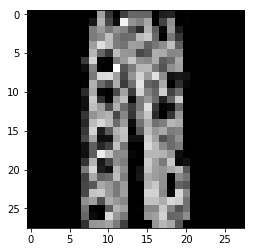

In [3]:
# Visualizing image 20 of the training set

sample_img = dftrain.iloc[20].tolist()
label, image = sample_img[0], sample_img[1:]
print(label)
im = np.array(image).reshape((28, 28))
plt.imshow(im, cmap='gray')

In [4]:
dftrain.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
44256,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40859,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,22,45,0,0
24514,3,0,0,0,0,0,0,0,0,0,...,23,0,0,0,0,0,0,0,0,0
35356,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24324,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### our datasets supports getitem wich means we can do:

In [5]:
image, label = fmnist_train[0]
print(type(image))
print(type(label), label)

image, label = fmnist_train.load_image_and_target(0)
print(type(image), image)

<class 'torch.Tensor'>
<class 'numpy.int64'> 9
<class 'PIL.Image.Image'> <PIL.Image.Image image mode=L size=28x28 at 0x12E421400>


In [6]:
fmnist_dl = DataLoader(fmnist_train, batch_size=32)
batch_iterator = iter(fmnist_dl)
X, y = next(batch_iterator)

for batch in fmnist_dl:
    break
    
print('y: ', batch[1].shape)
print('X: ', batch[0].shape)

y:  torch.Size([32])
X:  torch.Size([32, 1, 28, 28])


### Explore your dataset
Its always good to start with getting some inside about your dataset. Thats usually much easier and less important in image datasets - but it does not mean you should not do it.

Things you should always think about working with an image dataset are:
- Check target distribiution (counts) do you see a strong imbalance?
- Check sizes of images, if not all images are of the same size you might destroy your data with wrong transformations
 

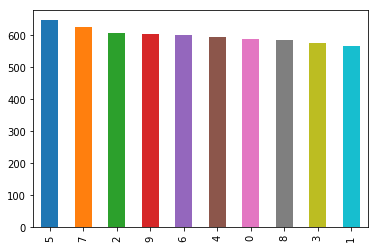

In [7]:
dftrain.label.value_counts().plot(kind='bar')

### visualize a batch
Its always a good idea to sanity check the output of our loaders

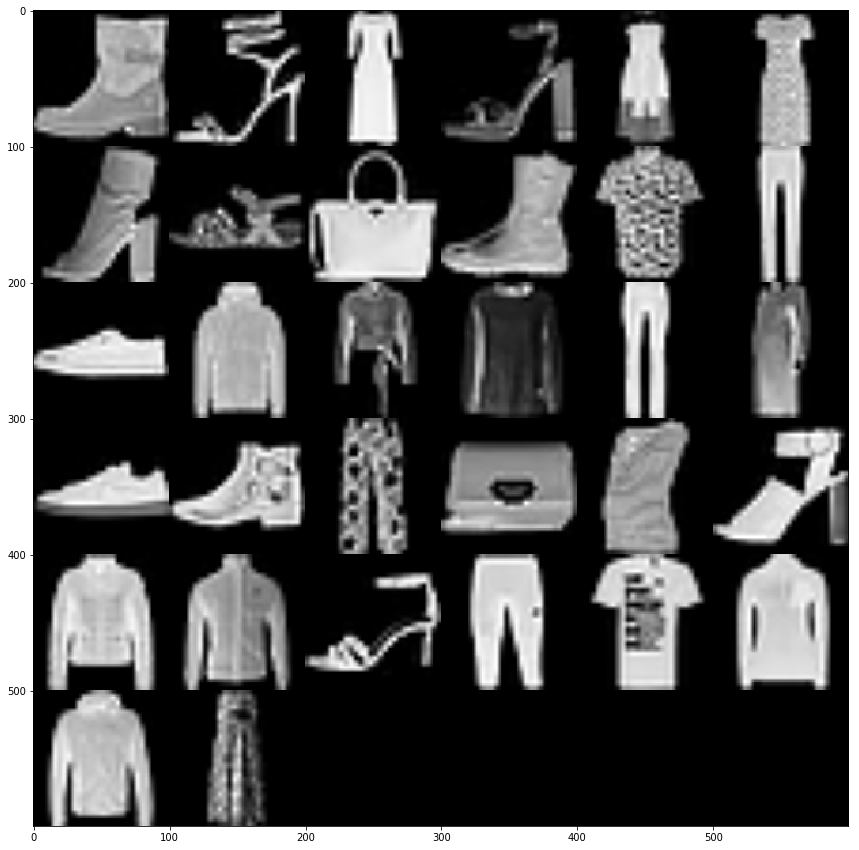

In [8]:
im = EasyImageList.from_torch_batch(X.repeat(1,3,1,1), # we need to add 3 channels to the images
                                    mean=None, std=None)
im.numpy_grid()

### Define your model architecture
As a baseline model dont  overcomplicate, either use some very simple architecture or go with something well established like resnet. There will be time to go more fancy

Here we define a model with two CONV blocks comprising of a typical:  
*Conv>BN>RELU>POOL* setting

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_of_class):
        super(SimpleCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            # 16 is the amount of filters/kernels, this is a design choice.
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Linear(7 * 7 * 32, num_of_class) # 7 comes from 2 times pooling: 28 -> 14 -> 7

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        
        # import pdb
        # pdb.set_trace()
        
        out = out.reshape(out.size(0), -1) # convert from torch.Size([32, 32, 7, 7]) to torch.Size([32, 1568])
        out = self.fc(out)
        return out

    
class SimpleLinearNN(nn.Module):
    def __init__(self, num_of_class):
        super(SimpleLinearNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, num_of_class))
        
    def forward(self, x):        
        x = x.reshape(x.size(0), -1)
        
        # import pdb
        # pdb.set_trace()
        
        out = self.layer1(x)
        return out
    
    
class AlternativeNN(nn.Module):
    def __init__(self, num_of_class):
        super(AlternativeNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(100, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, num_of_class))
        
    def forward(self, x):        
        x = x.reshape(x.size(0), -1)
        
        # import pdb
        # pdb.set_trace()
        
        out = self.layer1(x)
        return out

class SecondCNN(nn.Module):
    def __init__(self, num_of_class):
        super(SecondCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            # 32 is the amount of filters/kernels, this is a design choice.
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d())

        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d())
        
        self.fc = nn.Linear(7 * 7 * 16, num_of_class) # 7 comes from 2 times pooling: 28 -> 14 -> 7

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        
        #import pdb
        #pdb.set_trace()
        
        out = out.reshape(out.size(0), -1) # convert from torch.Size([32, 32, 7, 7]) to torch.Size([32, 1568])
        out = self.fc(out)
        return out

In [10]:
image = torch.randn(32, 1, 28, 28)
cnn = SecondCNN(10)
output = cnn(image)

In [11]:
# Always check your model are you at least able to make a forward pass and shapes match your expectations?
image = torch.randn(32, 1, 28, 28)
cnn = SecondCNN(10)
output = cnn(image)
print("input shape:")
print(image.shape)
print("output shape:")
print(output.shape)

input shape:
torch.Size([32, 1, 28, 28])
output shape:
torch.Size([32, 10])


In [12]:
# check how cross-entropy works
cross_entropy = nn.CrossEntropyLoss()
y_pred = torch.randn(32, 10)
y_target = torch.randint(10, (32,))

cross_entropy(y_pred, y_target)

tensor(2.9596)

### Define your loss function / crieterion and optimizer
Its a good idea to create some dummy data and pass it trough the cost function to make sure you uderstand what the shapes shoud be

In case of CrossEntropyLosss We want our predictions to be of shape (BATCH_SIZE, N_CLASSES) and y_true of shape (BS) 
(Basically a vector of number that corespond to the class) 


In [13]:
LR= 0.001
BATCH_SIZE = 32
DATASET_USAGE_SIZE = 0.05

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
RESIZE = 28

# cnn = SimpleCNN(10)
# cnn = AlternativeNN(10)
# cnn = SimpleLinearNN(10)
cnn = SecondCNN(10)

OPTIMIZER = 'Adam' # one of ['ASGD','Adadelta', 'Adagrad','Adam', 'Adamax','LBFGS', 'RMSprop','Rprop','SGD',SparseAdam']
optimizer = getattr(torch.optim, OPTIMIZER)(cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

cnn.to(DEVICE)

# Create dataset loaders

dftrain = pd.read_csv(os.getcwd() + '/data/fashion-mnist_train.csv').sample(frac=DATASET_USAGE_SIZE)
dftest = pd.read_csv(os.getcwd() + '/data/fashion-mnist_test.csv').sample(frac=0.1)

transform_train = transforms.Compose([transforms.Resize(RESIZE), transforms.ToTensor()])
fmnist_train = FashionMnist(dftrain, transform=transform_train)

transform_test = transforms.Compose([transforms.Resize(RESIZE), transforms.ToTensor()])
fmnist_test = FashionMnist(dftest, transform=transform_test)

fmnist_train_dl = DataLoader(fmnist_train, batch_size=BATCH_SIZE)
fmnist_test_dl = DataLoader(fmnist_test, batch_size=BATCH_SIZE)

# Lets try to use the criterion with dummy data
yp = torch.randn(BATCH_SIZE, 10)
yt = torch.randint(10, (BATCH_SIZE,))
criterion(yp, yt.long())

print(len(fmnist_train_dl))
print(len(dftrain))

94
3000


In [14]:
def evaluate_model(model, test_loader, print_info=False):
    with torch.no_grad():
        model.eval()
        collect_results = []
        collect_target = []
        for batch in test_loader:
            X, y = batch
            X = X.to(DEVICE)
            y = y.to(DEVICE).detach().cpu().numpy()
            pred = cnn(X)
            collect_results.append(pred.sigmoid().detach().cpu().numpy())
            collect_target.append(y) 
    
        preds_proba = np.concatenate(collect_results)
        preds = preds_proba.argmax(axis=1)
        
        targets = np.concatenate(collect_target)
        
        ll = log_loss(targets, preds_proba)
        acc = accuracy_score(targets, preds)
        if print_info:
            print("test log-loss: {}".format(ll))
            print("overall accuracy:  {}".format(acc))
            print(classification_report(targets, preds))
        model.train()
        
        return ll, acc
    
    
            
collect_metrics = []
collect_loss = []
for epoch in range(10):
    lossacc = 0
    for i, batch in enumerate(fmnist_train_dl):
        optimizer.zero_grad()
        X, y = batch
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        y_pred = cnn(X).sigmoid()
        
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()  
        collect_loss.append(float(loss.detach().cpu().numpy()))  
        
    lltest, acctest = evaluate_model(cnn, fmnist_test_dl)
    lltrain, acctrain = evaluate_model(cnn, fmnist_train_dl)
    collect_metrics.append([lltest, lltrain, acctest, acctrain])
    print("test: loss: {}  acc: {}".format(lltest, acctest))
    print("train: loss: {}  acc: {}".format(lltrain, acctrain))

evaluate_model(cnn, fmnist_test_dl, print_info=True)

test: loss: 1.2107329245060683  acc: 0.67
train: loss: 1.20488024777174  acc: 0.6733333333333333
test: loss: 0.992516683393158  acc: 0.681
train: loss: 0.9764582867848998  acc: 0.6843333333333333
test: loss: 0.9066713993570301  acc: 0.686
train: loss: 0.8854374311364178  acc: 0.6926666666666667
test: loss: 0.8647840037910209  acc: 0.696
train: loss: 0.8383856272474708  acc: 0.707
test: loss: 0.8468407565663947  acc: 0.712
train: loss: 0.81261583407604  acc: 0.731
test: loss: 0.8273225427019424  acc: 0.734
train: loss: 0.7740188935644073  acc: 0.7486666666666667
test: loss: 0.8090659960825906  acc: 0.744
train: loss: 0.7553642214176404  acc: 0.757
test: loss: 0.8016947484291904  acc: 0.754
train: loss: 0.7497758857579647  acc: 0.773
test: loss: 0.7558252003997814  acc: 0.763
train: loss: 0.700392609946603  acc: 0.7853333333333333
test: loss: 0.7365391103297413  acc: 0.765
train: loss: 0.6660664128454147  acc: 0.7856666666666666
test log-loss: 0.7365391103297413
overall accuracy:  0.765


(0.7365391103297413, 0.765)

<Figure size 432x288 with 0 Axes>

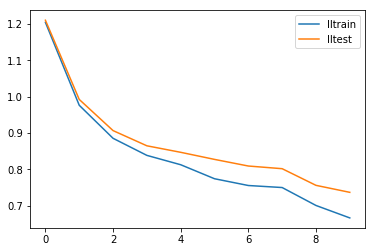

<Figure size 432x288 with 0 Axes>

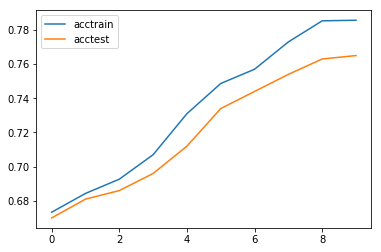

In [15]:
columns = ['lltest', 'lltrain', 'acctest', 'acctrain']

metrics_df = pd.DataFrame(collect_metrics, columns=columns)
plt.figure()
metrics_df[['lltrain', 'lltest']].plot()
plt.figure()
metrics_df[['acctrain', 'acctest']].plot()

In [27]:
collect_wrong_predictions = []
for i, batch in enumerate(fmnist_test_dl):
    X, y = batch
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    y_pred = cnn(X).sigmoid()

    for sample_X, sample_pred, sample_y in zip(X, y_pred, y):
        predicted = sample_pred.max(0)[1].item()
        if predicted != sample_y.item():
            collect_wrong_predictions.append(
                {'predicted': predicted, 
                 'label': sample_y.item(), 
                 'predicted_probability_of_real': sample_pred[sample_y].item(),
                 'prediction_vector': sample_pred,
                 'img': sample_X})

251
7
predicted: Sneaker
probability: 0.9702728986740112
real: Sandal


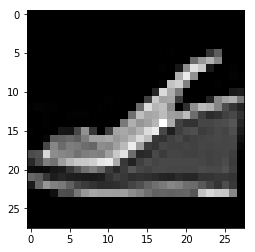

6
predicted: Shirt
probability: 0.9999960660934448
real: Coat


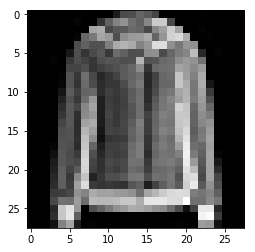

0
predicted: T-shirt/top
probability: 0.9836176633834839
real: Shirt


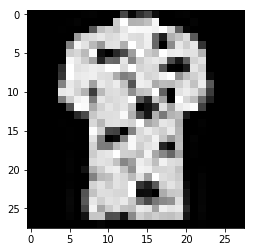

0
predicted: T-shirt/top
probability: 0.9928460717201233
real: Shirt


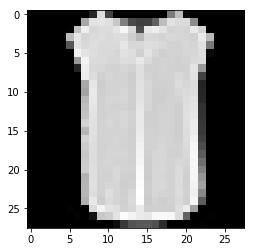

0
predicted: T-shirt/top
probability: 0.9957214593887329
real: Shirt


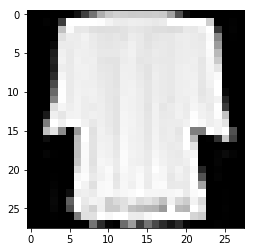

4
predicted: Coat
probability: 0.06295021623373032
real: Bag


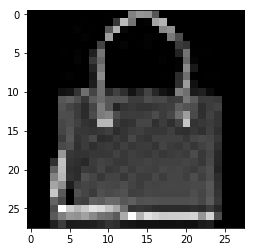

6
predicted: Shirt
probability: 0.9991299510002136
real: Pullover


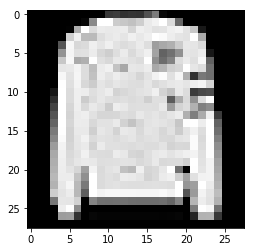

0
predicted: T-shirt/top
probability: 0.9999775886535645
real: Shirt


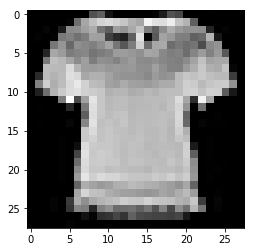

2
predicted: Pullover
probability: 0.9721880555152893
real: Coat


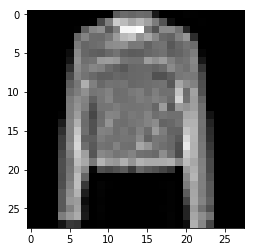

4
predicted: Coat
probability: 0.9980059266090393
real: Shirt


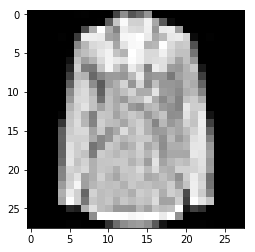

In [28]:
print(len(collect_wrong_predictions))
for i in range(10):
    print(collect_wrong_predictions[i]["predicted"])
    print(f'predicted: {label_dict[collect_wrong_predictions[i]["predicted"]]}')
    print(f"probability: {collect_wrong_predictions[i]['predicted_probability_of_real']}")
    print(f'real: {label_dict[collect_wrong_predictions[i]["label"]]}')
    plt.imshow(collect_wrong_predictions[i]['img'].numpy().squeeze(0), cmap='gray')
    plt.show()
    

### Questions/Exercises
- why do we use torch.no_grad():
- Try changing the kernel size of the CNN's what is your intuition should we use a smaller or bigger kernel?
- Get the output of the first cnn, look at its shape and how it looks
- Add dropout to the network, where does it make sense? To put it?
- 

# Crude LR-finder implementation

In [ ]:
losses = []
lrs = []

for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-7
    

for i, batch in enumerate(fmnist_train_dl):
    print(i)
    optimizer.zero_grad()
    X, y = batch
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    y_pred = cnn(X)

    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    current_lr = lr = optimizer.param_groups[0]['lr']
    print(loss)
    print(current_lr)
    losses.append(loss)
    lrs.append(current_lr)
    
    #losses.append(float(loss.detach().cpu().numpy()))  
    #losses.append(loss) 
    
    if loss > 10:
        break

    for param_group in optimizer.param_groups:
        param_group['lr'] = current_lr * 1.2


        
df = pd.DataFrame([l.detach().cpu().numpy() for l in losses])
df['lrs'] = lrs
#df = df[100:300]
ax = plt.plot(df['lrs'], df[0])
plt.xscale('log')


dftrain = pd.read_csv(os.getcwd() + 'fashion-mnist_train.csv').sample(frac=1)
fmnist_train = FashionMnist(dftrain, transform=transform_train)
data_loader = DataLoader(fmnist_train, batch_size=32)



INITIAL_LR = 10e-7
losses = []
lrs = []
cnn = SimpleCNN(10).cuda()
optimizer = getattr(torch.optim, OPTIMIZER)(cnn.parameters(), lr=0.001)

for param_group in optimizer.param_groups:
    param_group['lr'] = INITIAL_LR
    

for i, batch in enumerate(data_loader):
    if i % 100 == 0: 
        print(i)
        print(loss)
        
    optimizer.zero_grad()
    X, y = batch
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    y_pred = cnn(X)

    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    
    if loss > 10:
        break

    current_lr = lr = optimizer.param_groups[0]['lr']
    losses.append(loss)
    lrs.append(current_lr)

    for param_group in optimizer.param_groups:
        param_group['lr'] = current_lr * 1.03
        
    if i == 1000:
        break


    
df = pd.DataFrame([l.detach().cpu().numpy() for l in losses])
df['lrs'] = lrs
ax = plt.plot(df['lrs'], df[0])
plt.xscale('log')
